Ce notebook est dédié à la prédiction de la transcription sur l'ensemble du chromosome de levure ainsi que sur les génomes de bactérie intégrés dans la levure.

In [1]:
import numpy as np
import keras
import h5py
import os
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from MyModuleLibrary.array_modifier import rolling_window
from MyModuleLibrary.mykeras.losses import mae_cor, correlate

In [3]:
WINDOW = 2001
HALF_WX = WINDOW // 2

In [4]:
def one_hot_encoder(nucleotid):
    res = (np.arange(4) == nucleotid[..., None]-1).astype(int)
    res = res.reshape(res.shape[0], 4)
    return res

In [1]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=20)

# Prediction sur l'ensemble du génome de la levure

In [6]:
! cp ../Projet_RNA_seq/Results_RNA_seq/weights_myco_rep1.hdf5 ./models/weights_myco_rep1_transcription.hdf5
! cp ../Projet_RNA_seq/Results_RNA_seq/weights_pneu_rep1.hdf5 ./models/weights_pneu_rep1_transcription.hdf5

In [5]:
model = keras.models.load_model('./models/weights_myco_rep1_transcription.hdf5',
                                custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
def prepare_input(pathname, reverse=False):
    seq_chr = np.array(h5py.File(pathname)['data'])[:, 0]
    
    if reverse:
        seq_chr = seq_chr[::-1]
        seq_chr[seq_chr == 1] = 5
        seq_chr[seq_chr == 2] = 1
        seq_chr[seq_chr == 5] = 2
        seq_chr[seq_chr == 3] = 5
        seq_chr[seq_chr == 4] = 3
        seq_chr[seq_chr == 5] = 4
        
    length = len(seq_chr)
    seq_chr_onehot = one_hot_encoder(seq_chr)
    X = rolling_window(seq_chr_onehot, window=(WINDOW, 4))[:, 0, :, None, :]
    return X, length

In [7]:
def predict_and_save(pathname, outname):
    X, length = prepare_input(pathname)
    
    prediction = np.zeros((length,))
    y = model.predict(X)
    prediction[HALF_WX : -HALF_WX] = y[:, 0]
    np.save(outname, prediction)

In [9]:
for i in range(1, 17):
    predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5',
                     './results/yeast/transcription_myco_chr' + str(i) + '.npy')

In [10]:
predict_and_save('./data/bacterie/Mmm_Linear_740kb.hdf5',
                 './results/bacterial/transcription_myco.npy')

In [11]:
model = keras.models.load_model('./models/weights_pneu_rep1_transcription.hdf5',
                                custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})

In [12]:
for i in range(1, 17):
    predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5',
                     './results/yeast/transcription_pneu_chr' + str(i) + '.npy')

In [13]:
predict_and_save('./data/bacterie/Pneu300.hdf5',
                 './results/bacterial/transcription_pneu.npy')

# Représentation sur l'ensemble du génome

In [6]:
myco_yeast_files = ['./results/yeast/transcription_myco_chr' + str(i) + '.npy' for i in range(1, 17)]
pneu_yeast_files = ['./results/yeast/transcription_pneu_chr' + str(i) + '.npy' for i in range(1, 17)]

myco_file = ['./results/bacterial/transcription_myco.npy']
pneu_file = ['./results/bacterial/transcription_pneu.npy']

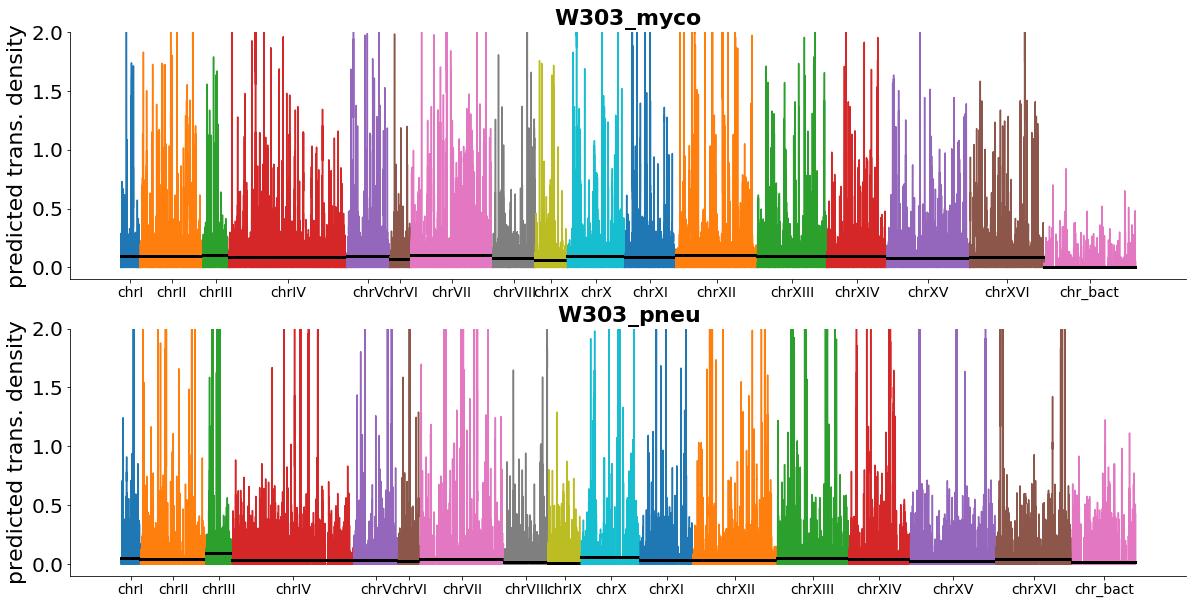

In [9]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for file in myco_yeast_files + myco_file:
    prediction = np.load(file)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)

ax.set_ylim([-0.1, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('predicted trans. density', fontsize=22)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for file in pneu_yeast_files + pneu_file:
    prediction = np.load(file)
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start +=len(prediction)

ax.set_ylim([-0.1, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneu}$', fontsize=22)
ax.set_ylabel('predicted trans. density', fontsize=22)

fig.savefig('./results/transcription.png')

In [14]:
pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_CPM_pneumo1.bed')
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_CPM4.bed')

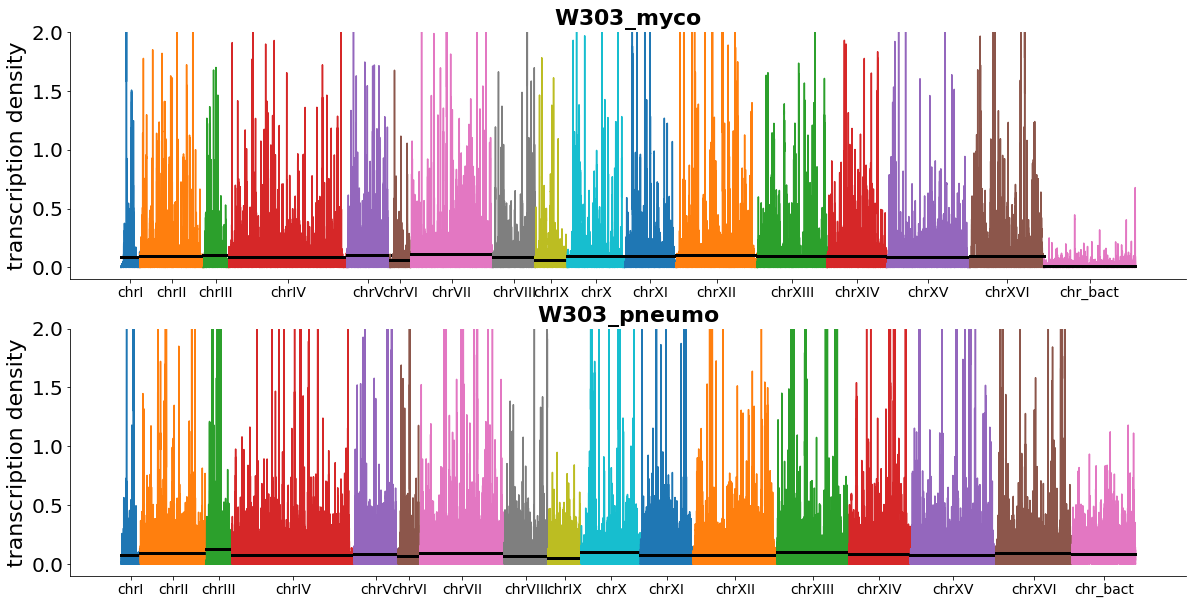

In [15]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Mmm_Linear_740kb.fa']:

    prediction = myco_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('transcription density', fontsize=22)
ax.set_ylim([-0.1, 2])

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Pneu300']:
    
    prediction = pneu_coverage_rep1[chrom]
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('transcription density', fontsize=22)
ax.set_ylim([-0.1, 2])

fig.savefig('./results/transcription_density_experimental.png')

In [ ]:
### Uploading the data to Projet_RNA_seq

In [98]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom: size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}

df = pd.DataFrame()

for chrom in chrom_size.keys():
    try:
        chr_ = chrom[:3] + str(int(chrom[3:]))
        local_df = pd.DataFrame()

        density = myco_coverage_rep1[chrom]
        local_df['chr'] = np.repeat(chr_, len(density))
        local_df['pos'] = np.arange(0, len(density))
        local_df['value'] = density

        df = df.append(local_df)
    except ValueError:
        pass

df.to_csv('../Projet_RNA_seq/Start_data/coverage_myco_rep1.csv')

In [99]:
df = pd.DataFrame()

for chrom in chrom_size.keys():
    try:
        chr_ = chrom[:3] + str(int(chrom[3:]))
        local_df = pd.DataFrame()

        density = pneu_coverage_rep1[chrom]
        local_df['chr'] = np.repeat(chr_, len(density))
        local_df['pos'] = np.arange(0, len(density))
        local_df['value'] = density

        df = df.append(local_df)
    except ValueError:
        pass
    
df.to_csv('../Projet_RNA_seq/Start_data/coverage_pneu_rep1.csv')

# Comparaison avec les données expérimentales

In [5]:
roman_to_num = {'chrI' : 'chr01', 'chrII' : 'chr02', 'chrIII' : 'chr03', 'chrIV' : 'chr04', 'chrV' : 'chr05',
                'chrVI' : 'chr06', 'chrVII' : 'chr07', 'chrVIII' : 'chr08', 'chrIX' : 'chr09', 'chrX' : 'chr10', 'chrXI' : 'chr11',
                'chrXII' : 'chr12', 'chrXIII' : 'chr13', 'chrXIV' : 'chr14', 'chrXV' : 'chr15', 'chrXVI' : 'chr16', 'chrM' : 'chrM'} 

In [11]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom: size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}

In [12]:
chrom_size['Mmm_Linear_740kb.fa'] = 1222199
chrom_size['Pneu300'] = 817946

In [13]:
def read_bed(pathname):
    df = pd.read_csv(pathname, names=['chrom', 'start', 'stop', 'density'], sep='\t')
    coverages = dict()
    for chrom in df.chrom.unique():
        if chrom in chrom_size:
            local_df = df[df.chrom == chrom]
            coverage = np.zeros(chrom_size[chrom])

            for start, stop, density in zip(local_df.start.values, local_df.stop.values, local_df.density.values):
                coverage[start : stop] = density
            coverages[chrom] = coverage
    
    all_coverage = np.concatenate([coverage for _, coverage in coverages.items()])
    threshold = np.sum(all_coverage) / 1e6
    
    for chrom, coverage in coverages.items():
        coverages[chrom] = np.log2(coverage / threshold + 1)
    return coverages

### Myco

In [37]:
prediction = np.load('./results/bacterial/transcription_myco.npy')

In [38]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_CPM4.bed')
#myco_coverage_rep2 = read_bed('./data/for_Julien/myco/coverage_CPM5.bed')
#myco_coverage_rep3 = read_bed('./data/for_Julien/myco/coverage_CPM6.bed')

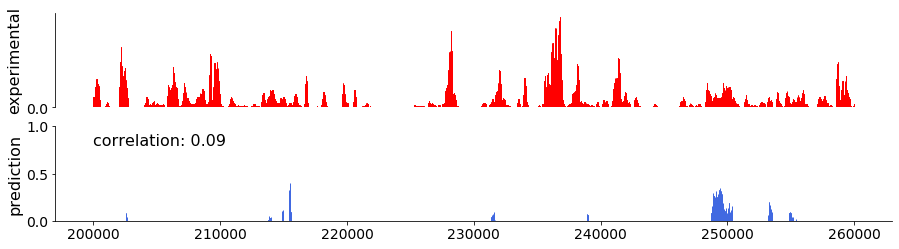

In [39]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 10000))
ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(myco_coverage_rep1['Mmm_Linear_740kb.fa'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=myco_coverage_rep1['Mmm_Linear_740kb.fa'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/transcription_exp_vs_pred_myco_rep1.png')

In [40]:
prediction = np.load('./results/yeast/transcription_myco_chr16.npy')

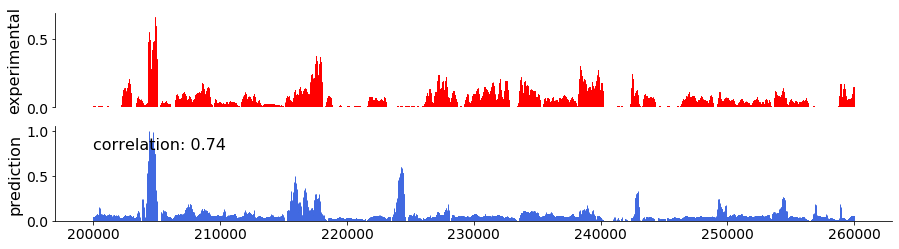

In [41]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 10000))
ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(myco_coverage_rep1['chr16'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=myco_coverage_rep1['chr16'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/transcription_exp_vs_pred_myco_chr16.png')

### Pneumo

In [42]:
prediction = np.load('./results/bacterial/transcription_pneu.npy')

In [43]:
pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_CPM_pneumo1.bed')

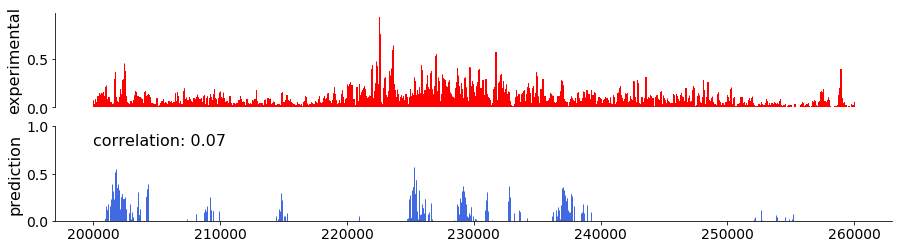

In [44]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 10000))
ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(pneu_coverage_rep1['Pneu300'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=pneu_coverage_rep1['Pneu300'][start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/transcription_exp_vs_pred_pneu_rep1.png')

In [45]:
prediction = np.load('./results/yeast/transcription_pneu_chr16.npy')

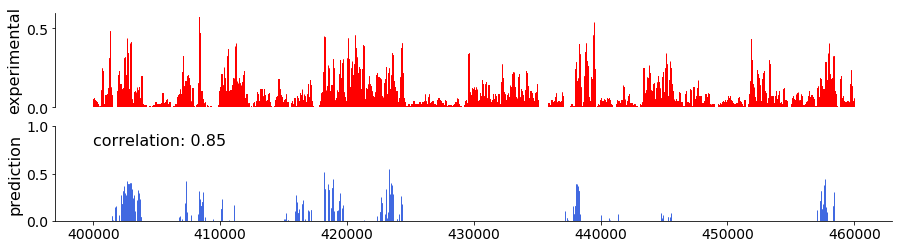

In [52]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 400000
stop = 460000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.set_facecolor('w')
ax.set_xticks(np.arange(start, stop + 1, 10000))
ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
ax.text(x=start,
        y=0.8,
        s='correlation: {}'.format(np.round(np.corrcoef(pneu_coverage_rep1['chr16'], prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 1.1, 0.5))
ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax1.bar(x=np.arange(start, stop), height=pneu_coverage_rep1['chr16'][start : stop], width=1, edgecolor='r')
#ax1.plot(np.arange(start, stop), pneu_coverage_rep1['chr16'][start : stop], color='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/transcription_exp_vs_pred_pneu_chr16.png')

In [ ]:
### Evaluation of the mean prediction with the CG-content

In [8]:
predict_and_save('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5',
              './results/covid19/transcription_coverage.npy')

In [9]:
def random_sequence(gc=0.4, batch_size=10000):
    return np.concatenate([one_hot_encoder(np.random.choice([1, 2, 3, 4],
                                                     WINDOW,
                                                     p=[0.5 - gc / 2., 0.5 - gc / 2., gc / 2., gc / 2.]))[None, ...]\
                                   for _ in range(batch_size)], axis=0)[:, :, None, :]

def get_gc_content(filename):
    seq_chr = np.array(h5py.File(filename)['data'])[:, 0]
    
    gc_content = np.unique(seq_chr, return_counts=True)[1]
    
    if len(gc_content) == 5:
        return np.sum(gc_content[3:]) / len(seq_chr)
    else:
        return np.sum(gc_content[2:]) / len(seq_chr)

In [10]:
means = [np.mean(model.predict(random_sequence(gc=gc))) for gc in np.arange(0, 1.05, 0.05)]
stds = [np.std(model.predict(random_sequence(gc=gc))) for gc in np.arange(0, 1.05, 0.05)]

In [13]:
gc_content_yeast = np.mean([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5') for i in range(1,17)])
mean_coverage_yeast = np.mean(np.concatenate([np.load('./results/yeast/transcription_myco_chr' + str(i) + '.npy') for i in range(1,17)]))
std_coverage_yeast = np.std(np.concatenate([np.load('./results/yeast/transcription_myco_chr' + str(i) + '.npy') for i in range(1,17)]))

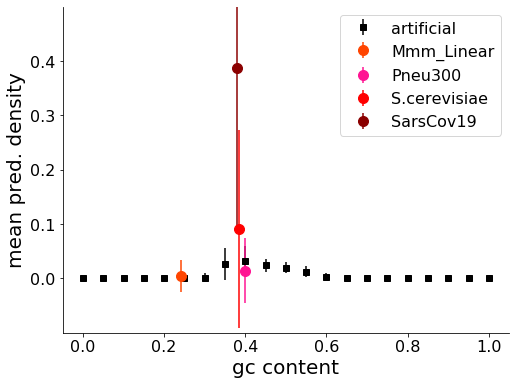

In [16]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(np.load('./results/bacterial/transcription_myco.npy'))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.load('./results/bacterial/transcription_myco.npy'))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(np.load('./results/bacterial/transcription_pneu.npy'))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.load('./results/bacterial/transcription_pneu.npy'))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [mean_coverage_yeast],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[std_coverage_yeast],
             color='red',
             label='S.cerevisiae')

ax.errorbar([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')],
            [np.mean(np.load('./results/covid19/transcription_coverage.npy'))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.load('./results/covid19/transcription_coverage.npy'))],
             color='darkred',
             label='SarsCov19')
ax.legend(fontsize=16)
ax.set_xticks(np.arange(0, 1.05, 0.2))
ax.set_xticklabels(np.round(np.arange(0, 1.05, 0.2), 2), fontsize=16)

ax.set_ylim([-0.1, 0.5])
ax.set_yticks(np.arange(0, 0.45, 0.1))
ax.set_yticklabels(np.round(np.arange(0, 0.45, 0.1), 2), fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)

fig.savefig('./results/gc_content_evolution_transcription.png')